In [1]:
import numpy as np
import control
from control import matlab
import matplotlib.pyplot as plt
from scipy import signal
from scipy import linalg as sc_linalg
import scipy.io as sio
import cmath

In [2]:
q = 2 # number of inputs
p = 2 # number of outputs
n = 100 # number of states

array([], dtype=float64)

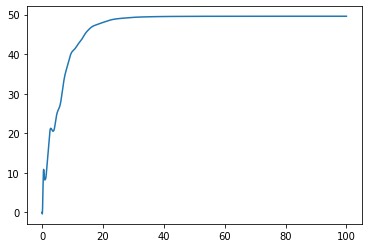

In [3]:
sysFull = control.rss(n, p, q, strictly_proper=True)
y, t = matlab.step(sysFull, T=100)
fig, ax = plt.subplots()
ax.plot(t, y[:, 0, 0])
sysFull_poles = matlab.pole(sysFull).real
sysFull_poles[sysFull_poles>0]

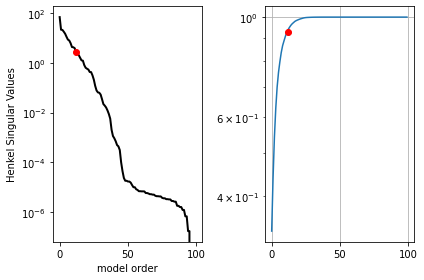

In [4]:
r = 12
hsvs = matlab.hsvd(sysFull)
hsvs = hsvs.real
plt.subplot(121)
plt.semilogy(hsvs, 'k', linewidth=2)
plt.semilogy(r, hsvs[r], 'ro', linewidth=2)
plt.xlabel('model order')
plt.ylabel('Henkel Singular Values')
plt.subplot(122)
plt.plot(np.arange(0, len(hsvs)), np.array(np.cumsum(hsvs)/np.sum(hsvs)))
plt.semilogy(r, np.sum(hsvs[0: r])/np.sum(hsvs), 'ro', linewidth=2)
plt.tight_layout()
plt.grid()
plt.show()

## balanced truncation

In [5]:
sysBT = control.balred(sysFull, r)

## BPOD

In [6]:
tFull, yFull, xFull = control.impulse_response(sysFull, T=np.arange(0, 50, 1), return_x=True)
yFull.shape # outp., inp., time

(2, 2, 50)

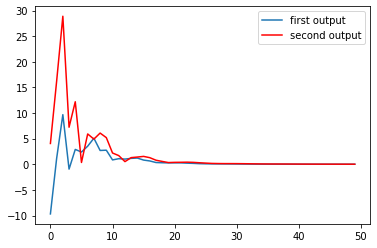

In [7]:
plt.plot(tFull, yFull[0, 0, :])
plt.plot(tFull, yFull[1, 0, :], 'r')
plt.legend(['first output', 'second output'])
plt.show()

In [8]:
A, B, C, D = sysFull.A, sysFull.B, sysFull.C, sysFull.D
sysAdj = matlab.ss(np.matrix.transpose(np.conj(A)), np.matrix.transpose(np.conj(C)), np.matrix.transpose(np.conj(B)), D)

In [9]:
tAdj, yAdj, xAdj = control.impulse_response(sysAdj, T=np.arange(0, 50, 1), return_x=True)
xAdj.shape

(100, 2, 50)

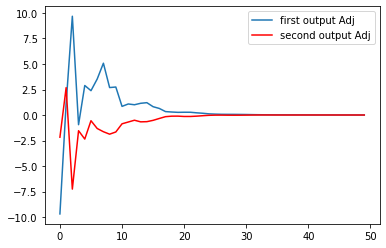

In [10]:
plt.plot(tAdj, yAdj[0, 0, :])
plt.plot(tAdj, yAdj[1, 0, :], 'r')
plt.legend(['first output Adj', 'second output Adj'])
plt.show()

### building the Henkel Matrix

In [11]:
for i in range(1, xAdj.shape[2]):
    Ystar = np.matrix.transpose(np.squeeze(xAdj[:,:,i]));
    for j in range(1, xFull.shape[2]):
        MarkovParameter = np.dot(Ystar, np.squeeze(xFull[:,:,i]));
        if j == 1:
            Hrow = MarkovParameter
        else:
            Hrow = np.concatenate((Hrow, MarkovParameter))
    Hrow = np.matrix.transpose(Hrow)
    if i == 1:
        HankelOC = Hrow
    else:
        HankelOC = np.concatenate((HankelOC, Hrow))

In [12]:
U, sig, V = sc_linalg.svd(HankelOC)
sigma_matrix = np.diag(sig)
for i in range(1, xFull.shape[2]):
    if i == 1:
        Xdata = np.matrix.transpose(np.squeeze(xFull[:, :, i]))
        Ydata = np.matrix.transpose(np.squeeze(xAdj[:, :, i]))
    else:
        Xdata = np.concatenate((Xdata, np.matrix.transpose(np.squeeze(xFull[:, :, i]))))
        Ydata = np.concatenate((Ydata, np.matrix.transpose(np.squeeze(xAdj[:, :, i]))))
Xdata = np.matrix.transpose(Xdata)
Ydata = np.matrix.transpose(Ydata)
psi = np.linalg.multi_dot([Xdata, V, sc_linalg.fractional_matrix_power(sigma_matrix, -0.5)])
phi = np.linalg.multi_dot([Ydata, U, sc_linalg.fractional_matrix_power(sigma_matrix, -0.5)])
sig

array([2.47757982e+02, 5.15293642e+01, 4.14674426e-14, 2.15237591e-14,
       2.15237591e-14, 2.15237591e-14, 2.15237591e-14, 2.15237591e-14,
       2.15237591e-14, 2.15237591e-14, 2.15237591e-14, 2.15237591e-14,
       2.15237591e-14, 2.15237591e-14, 2.15237591e-14, 2.15237591e-14,
       2.15237591e-14, 2.15237591e-14, 2.15237591e-14, 2.15237591e-14,
       2.15237591e-14, 2.15237591e-14, 2.15237591e-14, 2.15237591e-14,
       2.15237591e-14, 2.15237591e-14, 2.15237591e-14, 2.15237591e-14,
       2.15237591e-14, 2.15237591e-14, 2.15237591e-14, 2.15237591e-14,
       2.15237591e-14, 2.15237591e-14, 2.15237591e-14, 2.15237591e-14,
       2.15237591e-14, 2.15237591e-14, 2.15237591e-14, 2.15237591e-14,
       2.15237591e-14, 2.15237591e-14, 2.15237591e-14, 2.15237591e-14,
       2.15237591e-14, 2.15237591e-14, 2.15237591e-14, 2.15237591e-14,
       2.15237591e-14, 2.15237591e-14, 2.15237591e-14, 2.15237591e-14,
       2.15237591e-14, 2.15237591e-14, 2.15237591e-14, 2.15237591e-14,
      

In [13]:
Ar = np.linalg.multi_dot([np.matrix.transpose(phi[:, 0:r]), A, psi[:, 0:r]])
Br = np.dot(np.matrix.transpose(np.conj(phi[:, 0:r])), B)
Cr = np.dot(C, psi[:, 0:r])
Dr = D
sysBPOD = matlab.ss(Ar, Br, Cr, Dr)
Ar.shape

(12, 12)

In [14]:
tFull_test, yFull_test, xFull_test = control.impulse_response(sysFull, T=np.arange(0, 60, 1), return_x=True)
tBT_test, yBT_test, xBT_test = control.impulse_response(sysBT, T=np.arange(0, 60, 1), return_x=True)
tBPOD_test, yBPOD_test, xBPOD_test = control.impulse_response(sysBPOD, T=np.arange(0, 60, 1), return_x=True)
yBPOD_test.shape

(2, 2, 60)

ValueError: x and y must have same first dimension, but have shapes (60,) and (2,)

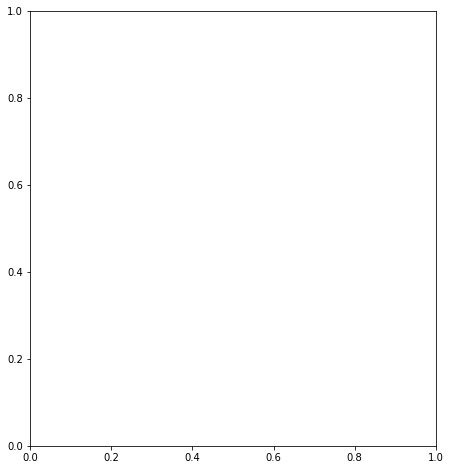

In [16]:
plt.figure(figsize=(16, 8))
plt.subplot(121)
plt.plot(tFull_test, yFull_test[:, 0, 0])
plt.plot(tBT_test, yBT_test[:, 0, 0], 'r')
# plt.plot(tBPOD_test, yBPOD_test[0, 0, :], 'g')
# plt.subplot(122)
# plt.plot(tFull_test, yFull_test[:, 1, 0])
# plt.plot(tBT_test, yBT_test[:, 1, 0], 'r')
# plt.plot(tBPOD_test, yBPOD_test[:, 1, 0], 'g')
plt.show()